## Vector search in Python (Azure AI Search)

This notebook demonstrates the basic understanding of Vector Search. We will look into Cosine Similarity, Text Search, and Vector Search examples.

### Setup Instructions

#### Step 1:  Prerequisites
- An Azure subscription, with access to Azure OpenAI. 
    - Deploy an embedding model from the Azure AI foundary post creation. Note the deployment name, embedding model name (text-embedding-ada-002). We need to change the .env file with the names.
    - Deploy an chat model.

- Azure AI Search Service provisioned.
- Visual Studio Code Installed in your system.

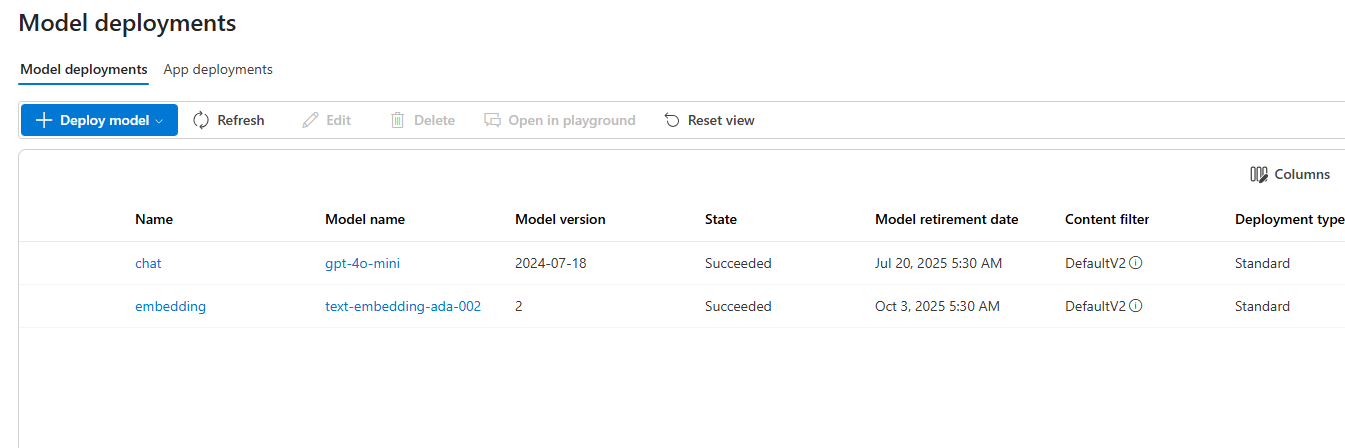

#### Step 2: create Python Virtual Environment

- Install Python in your machine. [Link](https://apps.microsoft.com/detail/9NCVDN91XZQP?hl=en-us&gl=US&ocid=pdpshare).
- run in terminal ` python -m venv <your-virtual-env-name> `
- activate the virtual environment ( for Powershell terminal) `<your-virtual-env-name>\Scripts\Activate.ps1`

#### Step 3: Install Packages


In [6]:
! pip install -r requirements.txt --quiet

#### Step 4: Update  environment File

rename the file `.env.example` to `.env` and fill the values accoridng to your environment.

### Let's execute the code.

#### Authentication to OpenAI Service

In [1]:
from openai import AzureOpenAI
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
import json
import os
# Set up OpenAI client based on environment variables

load_dotenv(override=True)


azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.getenv("AZURE_OPENAI_KEY", "") if len(os.getenv("AZURE_OPENAI_KEY", "")) > 0 else None
azure_openai_embedding_deployment = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT")
embedding_model_name = os.getenv("AZURE_OPENAI_ADA002_EMBEDDING_DEPLOYMENT")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2024-10-21")


openai_credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(openai_credential, "https://cognitiveservices.azure.com/.default")

client = AzureOpenAI(
    azure_deployment=azure_openai_embedding_deployment,
    azure_endpoint=azure_openai_endpoint,
    api_version=azure_openai_api_version,
    api_key=azure_openai_key,
    azure_ad_token_provider=token_provider if not azure_openai_key else None
)


#### Generating the embedding for a word

**Dimension of a vector 1536**

[text-embedding-ada-002](https://openai.com/index/new-and-improved-embedding-model/)

In [12]:
sentence = "automobile"
response = client.embeddings.create(model=embedding_model_name, input=sentence)
vector = response.data[0].embedding
len(vector)

1536

#### Lets look into the Vector Similarity Technique ( Cosine Similarity)

In [2]:
#Cosine Similarity

import numpy as np
import pandas as pd


def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

sentence1 = ['The quick brown fox jumps over the lazy dog.',
              'I love programming in Python.',
              'Artificial intelligence is fascinating.'
              ]

sentence2 = ['A fast brown fox leaps over a sleepy dog.',
              'Coding in Python is enjoyable.',
              'aaandmas'
              ]

def get_embeddings(sentences):
    embeddings_response = client.embeddings.create(model=embedding_model_name, input=sentences)
    return [embedding_object.embedding for embedding_object in embeddings_response.data]

embeddings1 = get_embeddings(sentence1)
embeddings2 = get_embeddings(sentence2)

for i in range(len(sentence1)):
    print(f"{sentence1[i]} \t\t {sentence2[i]} \t\t Score: {cosine_similarity(embeddings1[i], embeddings2[i]):.4f}")

The quick brown fox jumps over the lazy dog. 		 A fast brown fox leaps over a sleepy dog. 		 Score: 0.9470
I love programming in Python. 		 Coding in Python is enjoyable. 		 Score: 0.9236
Artificial intelligence is fascinating. 		 aaandmas 		 Score: 0.7496


### Reading the input file and creating the Embedding

In [7]:
# read the json file code\data\azure_products-documents.json

with open('data/azure_products-documents.json') as f:
    input_data = json.load(f)

# take the first 5 element from the input_data

# input_data = input_data[:5]


output_data = []
for i in input_data:
    output = {}
    content_embedding = client.embeddings.create(model=embedding_model_name, input= i['content']).data[0].embedding
    
    output['id']  = i['id']
    output['title'] = i['title']
    output['content'] = i['content']
    output['category'] = i['category']
    output['contentVector'] = content_embedding
    output_data.append(output)

# export the Output data

with open('data/azure_products-documents-output.json', 'w') as f:
    json.dump(output_data, f, indent=4)



### create search Index

In [8]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchFieldDataType,
    SearchableField,
    SearchField,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SemanticConfiguration,
    SemanticPrioritizedFields,
    SemanticField,
    SemanticSearch,
    SearchIndex,
    AzureOpenAIVectorizer,
    AzureOpenAIVectorizerParameters
)
from azure.identity import DefaultAzureCredential
import os

search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")

index_client = SearchIndexClient(
    endpoint=search_endpoint, credential=DefaultAzureCredential())
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="title", type=SearchFieldDataType.String, retrievable =True),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchableField(name="category", type=SearchFieldDataType.String,
                    filterable=True),
    SearchField(name="contentVector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile"),
    
]


# Configure the vector search configuration  
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnsw"
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw",
            vectorizer_name="myVectorizer"
        )
    ],
    vectorizers=[
        AzureOpenAIVectorizer(
            vectorizer_name="myVectorizer",
            parameters=AzureOpenAIVectorizerParameters(
                resource_url=azure_openai_endpoint,
                deployment_name=azure_openai_embedding_deployment,
                model_name=embedding_model_name,
                api_key=azure_openai_key
            )
        )
    ]
)



# semantic_config = SemanticConfiguration(
#     name="my-semantic-config",
#     prioritized_fields=SemanticPrioritizedFields(
#         title_field=SemanticField(field_name="title"),
#         keywords_fields=[SemanticField(field_name="category")],
#         content_fields=[SemanticField(field_name="content")]
#     )
# )

# # Create the semantic settings with the configuration
# semantic_search = SemanticSearch(configurations=[semantic_config])

# Create the search index with the semantic settings
index = SearchIndex(name="azure_products", fields=fields,
                    vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f'{result.name} created')

azure_products created


### Insert text and embeddings into vector store

In [9]:
from azure.search.documents import SearchClient
import json

# Upload some documents to the index
output_path = os.path.join('data', 'azure_products-documents-output.json')
output_directory = os.path.dirname(output_path)
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
with open(output_path, 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=search_endpoint, index_name="azure_products", credential=DefaultAzureCredential())
result = search_client.upload_documents(documents)
print(f"Uploaded {len(documents)} documents") 

Uploaded 216 documents


### Vector Search

In [10]:
### Vector Query

from azure.search.documents.models import VectorizedQuery

def get_embedding(text):
    get_embeddings_response = client.embeddings.create(model=embedding_model_name, input=text)
    return get_embeddings_response.data[0].embedding



AZURE_SEARCH_FULL_INDEX = "azure_products"
search_client = SearchClient(search_endpoint, AZURE_SEARCH_FULL_INDEX,
                             credential=DefaultAzureCredential())


search_query = "Suggest product for sending large events"
search_vector = get_embedding(search_query)
r = search_client.search(search_query, top=10, vector_queries=[
    VectorizedQuery(vector=search_vector, k_nearest_neighbors=50, fields="contentVector")
])


for doc in r:
    print(doc['title'], doc['category'], doc['@search.score'])


Azure Event Hubs Big Data 0.031159421429038048
Azure Data Explorer Analytics 0.03053613007068634
Azure Queue Storage Storage 0.029957523569464684
Azure Event Grid Integration 0.029726775363087654
Azure Batch Compute 0.02943722903728485
Azure HDInsight Analytics 0.028594771400094032
Azure Database for PostgreSQL Databases 0.027756938710808754
Azure Cache for Redis Databases 0.02698412910103798
Azure Database for MariaDB Databases 0.025925926864147186
Azure Data Factory Analytics 0.025653595104813576


In [11]:
#Normal Search

r = search_client.search(search_query) 
for doc in r:
    print(doc['title'], doc['category'], doc['@search.score'])

Azure Database for MariaDB Databases 3.7918355
Azure DevOps Developer Tools 3.5862749
Azure Database for PostgreSQL Databases 3.4531152
Azure Cache for Redis Databases 3.14085
Azure Database for MySQL Databases 3.14085
Azure API for FHIR Healthcare 3.14085
Azure Data Explorer Analytics 2.7688813
Azure Kubernetes Service (AKS) Containers 2.6856306
Azure HDInsight Analytics 2.6012852
Azure Event Hubs Big Data 2.3468874
Azure Batch Compute 2.080144
Azure Queue Storage Storage 1.9562218
Azure Data Factory Analytics 1.8540324
Azure App Service Web 1.8125224
Azure Table Storage Storage 1.5812824
Azure Event Grid Integration 1.4575477
Azure Machine Learning AI + Machine Learning 1.3710604
Azure Databricks Analytics 1.3292837
Azure HPC Cache Storage 1.1963742
Azure Data Bricks Analytics 1.1963742
Azure Synapse Analytics Analytics 1.1717747
Azure Key Vault Security 1.1683216
Azure Bot Service AI + Machine Learning 1.1683216
Azure Databricks Analytics 1.1075262
Azure Logic Apps Integration 1.107

In [13]:
import numpy as np
import pandas as pd
 
 
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
 
sentences1 = ['"The North Central US" , "northcentralus" , "usnorth"',
              ]
 
sentences2 = ['"north Central america"']
 
def get_embeddings(sentences):
    embeddings_response = client.embeddings.create(model=embedding_model_name, input=sentences)
    return [embedding_object.embedding for embedding_object in embeddings_response.data]
 
embeddings1 = get_embeddings(sentences1)
embeddings2 = get_embeddings(sentences2)
 
for i in range(len(sentences1)):
    print(f"{sentences1[i]} \t\t {sentences2[i]} \t\t Score: {cosine_similarity(embeddings1[i], embeddings2[i]):.4f}")

"The North Central US" , "northcentralus" , "usnorth" 		 "north Central america" 		 Score: 0.8909


Lets add some context to the sentence 

In [15]:
import numpy as np
import pandas as pd
 
 
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
 
sentences1 = ['"Azure Region "The North Central US" also known as "northcentralus" or "usnorth"'
              ]
 
sentences2 = ['"Azure Region: north Central america"',
              ]
 
def get_embeddings(sentences):
    embeddings_response = client.embeddings.create(model=embedding_model_name, input=sentences)
    return [embedding_object.embedding for embedding_object in embeddings_response.data]
 
embeddings1 = get_embeddings(sentences1)
embeddings2 = get_embeddings(sentences2)
 
for i in range(len(sentences1)):
    print(f"{sentences1[i]} \t\t {sentences2[i]} \t\t Score: {cosine_similarity(embeddings1[i], embeddings2[i]):.4f}")

"Azure Region "The North Central US" also known as "northcentralus" or "usnorth" 		 "Azure Region: north Central america" 		 Score: 0.9495
